/var/folders/xv/7qyvknjs2798tsdx99jj6c500000gn/T/ipykernel_81002/109937435.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


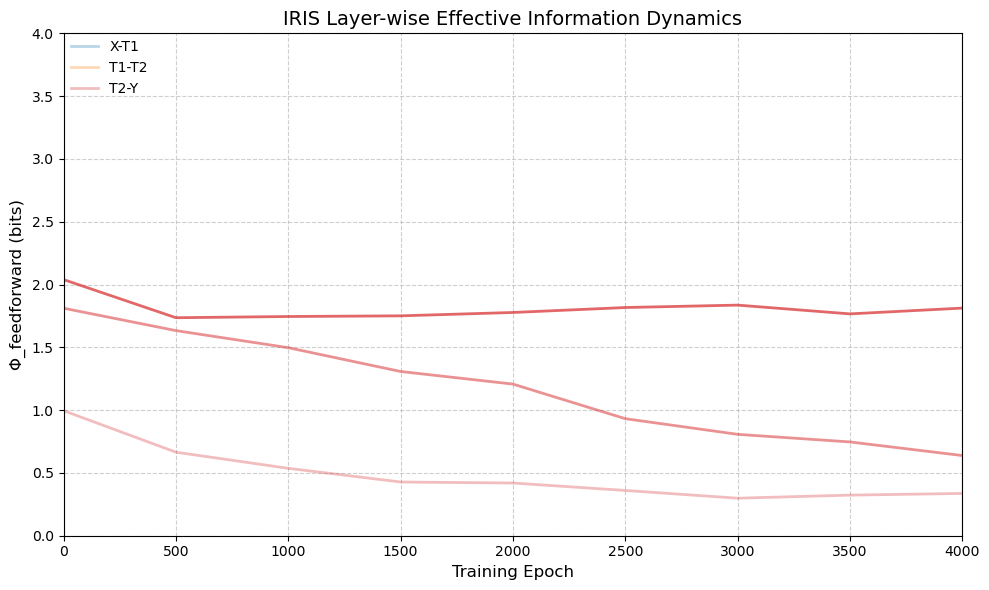

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 超参数设置
epochs = 4000
batch_size = 10
input_dim = 4
output_dim = 3
layer_dims = [4, 5, 5, 3]  # 网络结构
colors = ['#1f77b4', '#ff7f0e', '#d62728']  # 蓝、橙、红
num_runs = 3  # 运行次数

# 加载IRIS数据集
iris = load_iris()
X, y = iris.data, iris.target

# 数据预处理
scaler = StandardScaler()
X = scaler.fit_transform(X)  # 标准化
y = torch.tensor(y, dtype=torch.long)

# 将数据转换为PyTorch张量
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# 定义神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(layer_dims[0], layer_dims[1], bias=False), nn.ReLU(),  # 使用ReLU激活函数
            nn.Linear(layer_dims[1], layer_dims[2], bias=False), nn.ReLU(),
            nn.Linear(layer_dims[2], layer_dims[3], bias=False)
        )
        
        # 初始化权重
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')  # Kaiming初始化
        
        # 注册钩子捕获中间层输出
        self.activations = {}
        def get_activation(name):
            def hook(model, input, output):
                self.activations[name] = output.detach()
            return hook
        
        self.layers[0].register_forward_hook(get_activation('T1'))
        self.layers[2].register_forward_hook(get_activation('T2'))

    def forward(self, x):
        return self.layers(x)

# EI计算函数
def calculate_ei(input_dim, output_dim, layer_func, n_samples=1000):
    # 蒙特卡洛采样
    X = torch.rand(n_samples, input_dim) * 2 - 1  # 均匀分布[-1,1]
    
    log_dets = []
    for x in X:
        x = x.unsqueeze(0)  # 增加 batch 维度
        x.requires_grad_(True)  # 启用梯度计算
        
        # 计算输出
        y = layer_func(x)
        
        # 计算雅可比矩阵
        jacobian = torch.zeros((output_dim, input_dim))
        for i in range(output_dim):
            grad = torch.autograd.grad(y[0, i], x, retain_graph=True)[0]
            jacobian[i] = grad.squeeze(0)  # 去除 batch 维度
        
        # 处理非方阵：J @ J^T 的行列式
        det = torch.det(jacobian @ jacobian.T)
        log_dets.append(torch.log(torch.abs(det) + 1e-8).item())
    
    expectation = np.mean(log_dets)
    
    # 噪声估计（使用训练数据）
    X_val = torch.rand(1000, input_dim) * 2 - 1
    y_pred = layer_func(X_val)
    rmse = torch.sqrt(torch.mean((y_pred - y_pred.mean(dim=0))**2, dim=0))
    sigma_term = 0.5 * torch.sum(torch.log(rmse**2 + 1e-8))
    
    # NIS公式
    ei = input_dim * np.log(2) - 0.5 * output_dim * (1 + np.log(2 * np.pi)) - sigma_term + expectation
    
    # 检查 EI 值是否有效
    ei_np = ei.detach().numpy()  # 将 Tensor 转换为 numpy 数组
    if np.isnan(ei_np) or np.isinf(ei_np):
        return 0.0  # 返回一个默认值
    return ei.item()

# 多次运行实验
all_ei_history = []
for run in range(num_runs):
    # 初始化模型
    model = Net()
    optimizer = optim.SGD(model.parameters(), lr=0.001)  # 调整学习率
    criterion = nn.MSELoss()
    
    # 训练模型并计算EI
    ei_history = {'X-T1': [], 'T1-T2': [], 'T2-Y': []}
    for epoch in range(epochs):
        # 训练步骤
        model.train()
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size]
            batch_y = y[i:i+batch_size]
            
            optimizer.zero_grad()
            output = model(batch_X)
            target_onehot = torch.zeros(output.shape[0], output_dim).scatter_(1, batch_y.unsqueeze(1), 1.0)
            loss = criterion(output, target_onehot)
            loss.backward()
            optimizer.step()
        
        # 每500个epoch计算EI
        if epoch % 500 == 0 or epoch == epochs-1:
            model.eval()
            ei_history['X-T1'].append(calculate_ei(layer_dims[0], layer_dims[1], lambda x: model.layers[0](x)))
            ei_history['T1-T2'].append(calculate_ei(layer_dims[1], layer_dims[2], lambda x: model.layers[2](x)))
            ei_history['T2-Y'].append(calculate_ei(layer_dims[2], layer_dims[3], lambda x: model.layers[4](x)))
    
    # 保存每次运行的结果
    all_ei_history.append(ei_history)



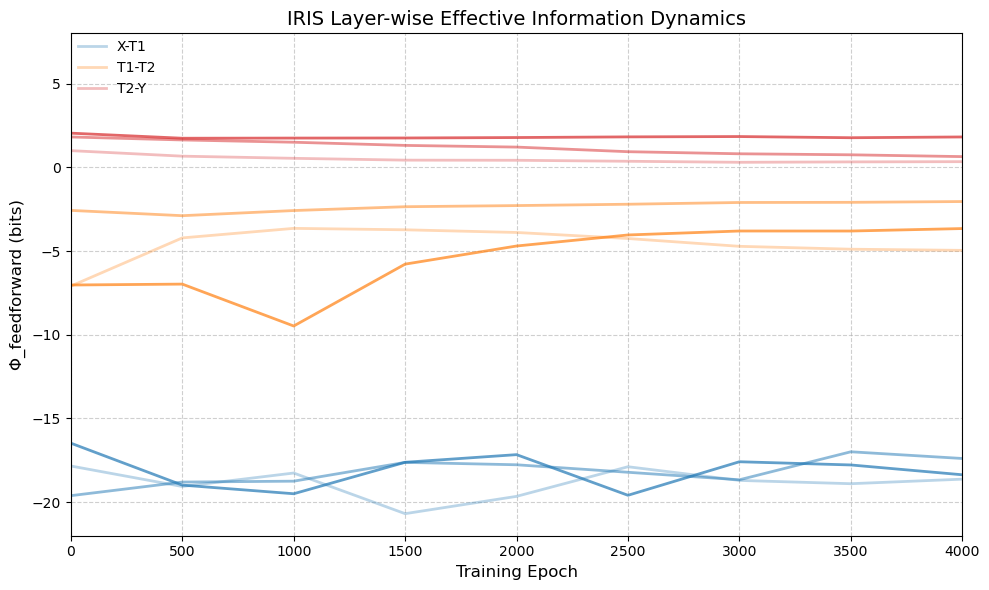

In [19]:
# 可视化多次运行结果
plt.figure(figsize=(10, 6), dpi=100)
x_ticks = np.arange(0, epochs, 500).tolist() + [epochs-1]

for idx, label in enumerate(['X-T1', 'T1-T2', 'T2-Y']):
    for run in range(num_runs):
        # 只在第一次运行时添加标签，其他运行不添加（避免重复图例）
        if run == 0:
            plt.plot(x_ticks, all_ei_history[run][label], 
                    color=colors[idx], 
                    alpha=0.3 + 0.2 * run, 
                    linewidth=2, 
                    label=label)
        else:
            plt.plot(x_ticks, all_ei_history[run][label],
                    color=colors[idx],
                    alpha=0.3 + 0.2 * run,
                    linewidth=2)

plt.xlabel('Training Epoch', fontsize=12)
plt.ylabel('Φ_feedforward (bits)', fontsize=12)
plt.title('IRIS Layer-wise Effective Information Dynamics', fontsize=14)

# 设置图例参数
plt.legend(
    loc='upper left',  # 图例位置改为左上角
    frameon=False,
    bbox_to_anchor=(0, 1),  # 精确定位锚点
    borderaxespad=0.1,      # 调整边距
    fontsize=10
)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, epochs)
plt.ylim(-22, 8)  # 纵坐标轴范围

plt.tight_layout()
plt.show()